# Reinforcement Learning &#x2013; TD learning

**Prerequisites**

- Linear Algebra
- Statistics and Probability
- Dynamic Programming
- Reinforcement Learning Introduction

**Outcomes**

- Understand the meaning of the $Q(s, a)$ function
- Understand the concept of a temporal difference
- Apply temporal differences to form an RL algorithm (Sarsa)

**References**

- Barto & Sutton book (online by authors [here](http://incompleteideas.net/book/the-book.html)) chapters 4-6
- [Stokey and Lucas (1989)](https://www.jstor.org/stable/j.ctvjnrt76) Chapter 4

## Reminder: Dynamic programming

- Let's begin by recalling what we know about dynamic programming
- Recall the cake eating problem:
    - Time is discrete
    - $\beta$ is discount factor
    - Size of cake is $\bar{x}$
    - Consumption of cake in period $t$ is $c_t$
    - Utility function $u: \mathbb{R} \rightarrow \mathbb{R}$ maps from consumption today into happiness

### Sequential Problem

- Objective
$$\begin{aligned}
\max_{c_t} &\sum_{t=0}^{\infty} \beta^t u(c_t) \\
\text{subject to } \quad & \sum_{t=0}^{\infty} c_t \le \bar{x} \\
& c_t \ge 0 \quad \forall t
\end{aligned}
$$
- Need to solve for *infinite* sequence $\{c_t\}_t$
- Or...

### Value Function

- We can set up a value function $$v(\bar{x}) \equiv \sum_{t=0}^{\infty} \beta^t u(c_t)$$
- $v(\bar{x})$ is the total *value* the consumer places on having a cake of size $\bar{x}$
- Decompose $v$ into two steps: first period + later periods $$v(\bar{x}) = \underbrace{u(c_0)}_{\text{flow utility}} + \underbrace{\beta \sum_{t=1}^{\infty} \beta^{t-1} u(c_t)}_{\text{continuation utility}}$$

### Recursive Formulation

- Note: continuation utility depends on $x_{t+1} = x_t - c_t$
- Use this observation to write $v: \mathbb{R}^+ \rightarrow \mathbb{R}$ recursively:
$$\begin{aligned}
  v(x_t) &= \max_{0 \leq c_t  \leq x} \underbrace{u(c_t)}_{\text{flow utility}} + \underbrace{\beta v(x_t - c_t)}_{\text{continuation value}}
\end{aligned}$$
- This is known as the **Bellman Equation**

### Solution to Recursive Problem

- A solution to the dynamic program consists of two functions:
    1. **Value function** $v^*(x): \mathbb{R}^+ \rightarrow \mathbb{R}$ -- value of beginning period with $x$ cake remaining
    2. **Policy function** $c^*(x): \mathbb{R}^+ \rightarrow [0, x]$ -- optimal level of consumption with $x$ cake remaining
- Under certain regularity conditions (which we assume), the recursive problem (and its solution) is equivalent to the sequential problem we started with

### Connection to RL

- How does this connect to RL?
- (S, A, R) pattern for RL is very closely related to recursive formulation of dynamic programming
    - $S_t \Longrightarrow x_t$
    - $A_t \Longrightarrow c_t$ 
    - $R_t \Longrightarrow u(c_t)$
- Expressing $v(x) = \text{flow utility} + \text{ continuation value}$ is like repeating (S, A, R) sequence many times
- Baseline algorithm for solving DP problem (VFI) is quite similar to how basic RL algorithms work
    - Start with guess for value, make decision, update guess, repeat...

## TD-Learning



### Baseline Assumptions

- Let state space $\mathcal{S}$ and action space $\mathcal{A}$ be discrete
- Let $S_t \in \mathcal{S}$  represent state at time $t$
- Let $A_t \in \mathcal{A}(S_t)$ represent action at time $t$
- Let $R_{t+1} \in \mathcal{R} \subseteq \mathbb{R}$ represent reward at time $t+1$
- Let state transitions satisfy the Markov property such that 
$$
\begin{aligned}
& p(s', r | s, a) = \text{Prob}(S_{t+1}=s', R_{t+1}=r | S_{t} = s, A_{t} = 1) \\
\text{ where } \quad & \sum_{s' \in \mathcal{S}} \sum_{R \in \mathcal{R}} p(s', r | s, a) = 1 \quad \forall s \in \mathcal{S}, a \in \mathcal{A}(S) \\
\text{ and } \quad & p(s', r | s, a) \ge = 0 \quad \forall s, s' \in \mathcal{S}, a \in \mathcal{A}(s), r \in \mathcal{R}
\end{aligned}
$$

> Note *Markov* means that probability for $S_{t+1}, R_{t+1}$ only depends on $S_t, A_t$ and not and $S_i, A_i, R_i$ where $i < t$

### State Value Function

- Let $v^*(s)$ be the optimal value of being in state $s$ (called *state value function*)
- We write this as:
$$
\begin{aligned}
v^*(s) &= \max_{a \in \mathcal{A}(s)} E \left[R_{t+1} + \beta v^*(S_{t+1}) | S_t=s, A_t=a \right] \\
&= \max_{a \in \mathcal{A}(s)} \sum_{s', r} p(s', r | s, a) \left[ r + \beta v^*(s') \right]
\end{aligned}$$
- Should be familiar from our dynamic programming studies
- Note expectation around the flow utility term $R_{t+1}$, leaving room for that reward to be stochastic

### Action Value Function

- We can also write an *action value function*
- Let $q^*(s, a)$ be the optimal value of being in state $s$ and choosing action $a$:
$$
\begin{aligned}
q^*(s, a) &= E \left[R_{t+1} + \beta \max_{a' \in \mathcal{A}(S_{t+1})} q^*(S_{t+1}, a') | S_t=s, A_t=a \right] \\
&= \sum_{s', r} p(s', r | s, a) \left[ r + \beta \max_{a' \in \mathcal{A}(S_{t+1})} q^*(s', a') \right]
\end{aligned}$$
- Notice max operator is now *inside* the expectation and applied to future decision $a'$
- The function $q^*(s, a)$ is more general than $v^*(s)$: $$v^*(s) = \max_{a \in \mathcal{A}(s)} q^*(s, a)$$

### Acting with $q^*$

- Goal of RL is to learn to make decisions that maximize $\sum \beta^t R_t$
- Knowing $q^*(s, a)$ tells us maximium value of being in state $s$ and choosing $a$
- If we *knew* $q^*$, acting optimally would be easy: $$a^*(s) = \text{argmax}_{a
           \in \mathcal{A}(s)} q^*(s, a)$$
- However, we rarely if ever *know* $q^*$, so we must approximate it
- We will let $Q(s, a)$ represent our *approximation* of $q^*$

### Approximating $q^*$

- The goal of TD learning is to find an accurate approximation $Q(s, a)$ such that $Q(s, a) \approx q^*(s, a) \; \forall s, a)$
- There are many RL algorithms that seek to do this
- We'll focus on two:
    - Sarsa
    - Q-learning

## Temporal Differences


- The Bellman equaition for our approximation $Q(s, a)$ is $$Q(s,a) = E[R' + \beta \max_{a'} Q(s', a') | s,a]$$
- Suppose that we interacted with environment and have in hand $(S_t, A_t, R_{t+1}, S_{t+1}, A_{t+1})$
- Now we plug these into the Bellman by:
    1. Using the form of the Bellman
    2. But drop $E$ and $\max$ because we already know the transition that did occur from $(S_t, A_t, R_{t+1}, S_{t+1}, A_{t+1})$
    3. Change $=$ an $\approx$ because this isn't evaluating full Bellman
$$Q(S_t,A_t) \approx R_{t+1} + \beta  Q(S_{t+1}, A_{t+1})$$
- The difference between the left and right and sides is known as a temporal difference: $$TD(0)(Q) \equiv R_{t+1} + \beta Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t)$$

> There are extensions to the temporal difference that allow for multiple time periods. The 0 in $TD(0)$ indicates that this is *one-step* TD learning. See Chapters 7 and 12 of Sutton/Barto for more info

### Learning using TD(0)

- We can use temporal differences to *improve* our approximation $Q$:
- Let $Q_t(s, a)$ represent our approximation at the start of period $t$
- Similar to gradient descent methods, we will take a step from $Q_t$ in a direction that improves its accuracy
- To improve accuracy we step in direction of $TD(0)(Q_t)$ (using step size $\alpha$): 
$$
\begin{aligned}
Q_{t+1}(S_t, A_t) &= Q_t(S_t, A_t) + \alpha TD(0)(Q_t) \\
&= Q_t(S_t, A_t) + \alpha \left[R_{t+1} + \beta Q_t(S_{t+1}, A_{t+1}) - Q_t(S_t, A_t) \right]
\end{aligned}
$$

### Sarsa Algorithm

- The Sarsa algorithm applies the update rule we just described
- The algorithm is summarized by Barto and Sutton as follows (section 6.4)

![sarsa_barto_sutton.png](./sarsa_barto_sutton.png)

In [1]:
from collections import defaultdict
import random

import numpy as np
import matplotlib.pyplot as plt

In [2]:
class TabularQ:
    def __init__(self):
        self.Q = defaultdict(lambda: 0)

    def __call__(self, s, a):
        return self.Q[(s.observable_state(), a)]

    def __setitem__(self, k, v):
        s, a = k
        self.Q[(s.observable_state(), a)] = v

    def get_greedy(self, s, A_s):
        vals = [self(s, a) for a in A_s]
        max_val = max(vals)
        return random.choice([a for (a, v) in zip(A_s, vals) if v == max_val])

In [3]:
class Sarsa(object):
    def __init__(self, environment, epsilon=0.9, alpha=0.1, beta=1.0):
        self.env = environment
        self.Q = TabularQ()
        self.epsilon = epsilon
        self.alpha = alpha
        self.beta = beta

        self.restart_episode()

    def restart_episode(self):
        # These will be (S, A) in our notation. Need to initialize
        self.s = self.env.reset()
        self.a = self.act(self.s, self.env.enumerate_options(self.s))

    def get_greedy(self, s, A_s):
        return self.Q.get_greedy(s, A_s)

    def act(self, s, A_s):
        if random.random() > self.epsilon:
            return random.choice(A_s)
        return self.get_greedy(s, A_s)

    def done(self, s=None) -> bool:
        return self.env.done(s if s else self.s)

    def step(self):
        # first take the step (s, a)
        s, a = self.s, self.a
        sp, r = self.env.step(s, a)

        if self.done(sp):
            # game is over
            self.s = sp
            return

        # then use policy to compute ap
        A_sp = self.env.enumerate_options(sp)
        ap = self.act(sp, A_sp)

        # now we know S-A-R-S'-A' -- ready to do update
        Q, α, β = self.Q, self.alpha, self.beta  # simplify notation
        Q[(s, a)] = Q(s, a) + α * (r + β * Q(sp, ap) - Q(s, a))

        # step forward in time
        self.s = sp
        self.a = ap

### Example: Farkle

- In a separate video we implemented the dice game farkle
- We'll re-use that code as an environment for `Sarsa` algorithm
- For a review of farkle, see video
- Today we'll approach it like the RL algorihtm will: 
    - A stochastic environment that sends states, a list of possible actions, and rewards
    - We will *not* specialize based on rules of game

### Farkle env

- Let's wrap farkle code into environment `Sarsa` expects
- Need a few key methods:
    - `reset() -> State`
    - `enumerate_options(state) -> List[Action]`
    - `step(s: State, a: Action) -> Tuple[State, Reward]`
    - `done(s:State) -> bool`

In [4]:
from farkle import State, Action, RandomFarklePlayer, FarklePlayer, STOP, BANKRUPT
from typing import List, Tuple

class FarkleEnv:
    # first, some helper methods
    def __init__(
            self,
            opponent: FarklePlayer=RandomFarklePlayer(),
            points_to_win=10_000,
            verbose: bool = False
        ):
        self.points_to_win = points_to_win
        self.opponent = opponent
        self.n_players = 2
        self._state = State(self.n_players)
        self._history: List[Tuple[State, Action]] = []

    @property
    def state(self) -> State:
        return self._state

    def set_state(self, action: Action, new_state: State):
        self._history.append((self.state, action))
        self._state = new_state

    def opponent_turn(self, s: State) -> State:
        choices = s.enumerate_options()
        action = self.opponent.act(s, choices)
        sp = s.step(action)

        # check if player chose to stop
        if sp.current_player != 1:
            return sp

        # Player didn't stop, but still their turn. Call again
        return self.opponent_turn(sp)

    # key methods needed
    def done(self, state) -> bool:
        return any(score > self.points_to_win for score in state.scores)

    def reset(self):
        self._state = State(self.n_players)
        self._history = []
        return self.state.roll()

    def step(self, s: State, a: Action) -> Tuple[State, int]:
        sp = s.step(a)
        r = 0

        # see if we ended
        if sp.current_player != 0:
            if a is STOP:
                # only score when we choose to stop
                r = s.turn_sum

            # take opponent turn
            sp = self.opponent_turn(sp)

        self.set_state(a, sp)
        return sp, r

    def enumerate_options(self, s: State) -> List[Action]:
        return self.state.enumerate_options(s.rolled_dice)

#### Playing Farkle

- Let's try it out!
- We need to create an env, then pass it to sarsa
- We'll also define a helper function to play a game for us

In [5]:
env = FarkleEnv()
sarsa = Sarsa(env, epsilon=0.9, alpha=0.6)

In [6]:
def play_game(algo):
    algo.restart_episode()
    while not algo.done():
        algo.step()
    return algo

In [7]:
play_game(sarsa)
sarsa.s

Round: 70. Score: [10050, 7450]

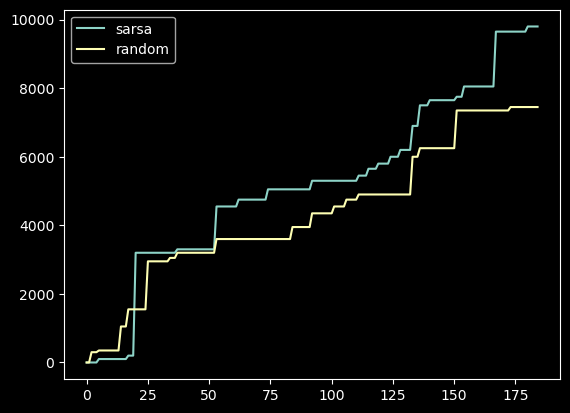

In [8]:
scores = [h[0].scores for h in env._history]
plt.plot(scores)
plt.legend(["sarsa", "random"])

In [9]:
from farkle import HumanFarklePlayer
env_human = FarkleEnv(opponent=HumanFarklePlayer(name="Spencer"), points_to_win=2000)
sarsa_human = Sarsa(env_human)

In [10]:
# play_game(sarsa_human)

In [11]:
sarsa_human.s

Round: 0. Score: [0, 0]

#### Learning

- Great! Our algorithm can play Farkle
- But... it needs to play *many* games to learn how to play well
- Let's let it play many more games to build up some intelligence

In [ ]:
%%time

def play_many_games(N):
    terminal_states = []
    print_skip = N // 10
    for i in range(N):
        play_game(sarsa)
        terminal_states.append(sarsa.s)
        if i % print_skip == 0:
            print(f"Done with {i}/{N} (len(Q) = {len(sarsa.Q.Q)})")
    return terminal_states

# WARNING: this takes a *long time* and requires a lot of ram!
# Only use on a computer with at least 32 GB ram
# There are ways we could optimize this... such as only including
# final score in `terminal_states` and dropping things like current_round
# from the state
sarsa_history = play_many_games(10000)

Done with 0/20000 (len(Q) = 385)
Done with 2000/20000 (len(Q) = 9030)
Done with 4000/20000 (len(Q) = 10516)
Done with 6000/20000 (len(Q) = 11895)
Done with 8000/20000 (len(Q) = 12958)
Done with 10000/20000 (len(Q) = 14040)
Done with 12000/20000 (len(Q) = 14726)


KeyboardInterrupt: 

#### Did we learn?

- Let's analyze the history and see if the algorithm learned with experience

In [ ]:
won = np.array([s.scores[0] > s.scores[1] for s in sarsa_history])
game_idx = np.arange(len(won))

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(game_idx, won.cumsum())
ax.plot(game_idx, 0.5 * game_idx)
plt.legend(["sarsa", "E[random agent]"])